In [1]:
# Text cleaning
import re
import math
from bs4 import BeautifulSoup
import itertools  

# data engineering
import pandas as pd
import numpy as np
import time

# Visualization
import matplotlib.pyplot as plt

# Sentence similarity and topic modeling
import torch
import hdbscan
import umap
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)
%matplotlib inline

In [2]:
df_text = pd.read_csv('data.csv', nrows=10000)

## Text Cleaning

In [3]:
# df_text.rename(columns = {'Unnamed: 0':'news_id'}, inplace = True)
df_text.drop(columns = ['Unnamed: 0'], inplace = True)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [4]:
if df_text.duplicated(subset=['description']).any():
    print('duplicated records found:\n', df_text[df_text.duplicated(subset=['description'])])
    
    df_text.drop_duplicates(subset = ['description'], inplace=True)
    df_text.dropna(subset = ['description'], axis=0, inplace=True)
    df_text.reset_index()

duplicated records found:
                                                                                                                                                                                                                                                                                                                                                                                            description
3628                                                                                               AP - Apple Computer Inc. stock jumped to a four-year high Monday after a major Wall Street firm nearly doubled its price target on the stock, saying that customer satisfaction with its iPod music player is creating "wildfire word-of-mouth marketing" for its Mac computers and other products.
4026                                                                                                                                                                                           

### Expanding the contractions
> Performing basic preprocessing steps is very important before we get to the model building part.
> Using messy and uncleaned text data is a potentially disastrous move.<br />
> So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                    "you're": "you are", "you've": "you have",
                    "u.s.": "unitedstate", "uk":"unitedkingdom"}

### Cleaning Steps:
    1. convert everything to lowercase    
    2. Removing any web (ie.html) tags from datatset using beutifulsoup library 
    3. Contraction Mapping to change abbrevated statments to understandable english
    4. Remove `'s` and text within parenthesis
    5. Eliminate punctuations and special characters
    6. Remove stopwords
    7. Remove token words which are 1 charecter long 
    8. Remove extra white spaces within words
    
    

In [6]:
# Here we are using regular expression library to clean data
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    newString = re.sub(' +', ' ', newString)
    
    return newString

In [7]:
# text_cleaner(df_text['description'][1])
df_text['cleaned_description'] = df_text['description'].apply(text_cleaner)
df_text.head(3)

,description,cleaned_description
0,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said.",dubai the group led by al qaeda ally abu musab al zarqawi said it beheaded two iraqi soldiers in broad daylight in mosul a statement found on an islamist web site on friday said
1,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbook with red carpets, glittering gems and a live nationwide broadcast.",santa monica calif the stars of the video game industry came out in force on tuesday night to honor their peers for creative excellence taking a page from the hollywood playbook with red carpets glittering gems and a live nationwide broadcast
2,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody.",ap a week of rallies marches and nearly arrests left anti bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody


In [8]:
summary = df_text['cleaned_description'].to_list()
corpus, queries = train_test_split(summary, train_size=9000, test_size=50)
print(f"Train:{len(corpus)} Validate: {len(queries)}")

Train:9000 Validate: 50


In [9]:
text_word_count = []

# populate the lists with sentence lengths
for i in df_text['cleaned_description']:
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count})

In [10]:
text_word_count[0]

34

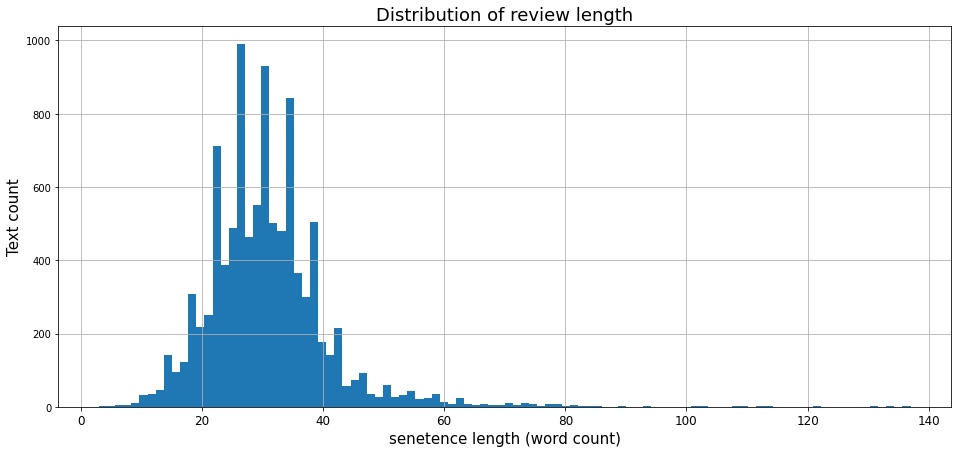

In [11]:
length_df.text.hist(bins = 100, figsize=(16,7), xlabelsize=12)
plt.xlabel('senetence length (word count)', fontsize=15)
plt.ylabel('Text count', fontsize=15)
plt.title('Distribution of review length', fontsize=18)
plt.show()

## Sentence-BERT: 
#### Modified BERT which uses siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be computed using cosine similarity. Sentence-BERT produce fixed-sized sentence embeddings. 

In [12]:
# embd_model = SentenceTransformer('distilbert-base-nli-mean-tokens')  --- Good for topic modeling
embd_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
# embd_model = SentenceTransformer('msmarco-distilbert-base-v3')---not good for sentence embedding
# embd_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
# embd_model = SentenceTransformer('stsb-roberta-base')


In [13]:
# set word length (input argument as hyperparameter)
embd_model.max_seq_length = 150 

### Embedding:
### Siamese network: **A Siamese Neural Network is architectures that contain two or more identical subnetworks. It is used to find the similarity of the inputs by comparing its feature vectors.**
We provide senetnces to each subnetwork to compute similarities.
1. BERT: We use pretrained BERT to generate senetnce Embedding for each sentence
2. Pooling: SBERT adds a pooling operation to the output of BERT to derive a fixed sized sentence embedding.
    - The default pooling strategy is to compute the mean of all output vectors
    - We generate u and v sentence embeddings for respective sentence
3. Concatenate: We concatenate the sentence embeddings u and v with the element-wise difference |u−v| and multiply it with the trainable weight
4. Softmax: The classification objective function is optimized with cross-entropy loss

In [14]:
corpus_embeddings = embd_model.encode(corpus, convert_to_tensor=True, show_progress_bar=True, device='cuda')

### Inference with Sentence-BERT:
- Sentence-BERT uses a regressive objective function for inference within a siamese network
- The cosine similarity between two sentence embeddings (u and v) are computed as a score between (-1, 1)
- The regressive objective function is optimized with mean-squared-error loss
- Concatenation is not required before calculating the cosine similarity of the sentence embeddings.

In [15]:
#Print the embeddings
i = 0
for sentence, embd in zip(df_text['cleaned_description'], corpus_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embd)
    print("")
    if i == 5:
        break
    i+=1

Sentence: dubai the group led by al qaeda ally abu musab al zarqawi said it beheaded two iraqi soldiers in broad daylight in mosul a statement found on an islamist web site on friday said 
Embedding: tensor([-4.4609e-01, -3.1998e-02,  3.3063e-01, -5.4117e-01, -5.4913e-01,
        -9.4566e-01, -1.7069e-02, -7.0706e-01,  6.6171e-01, -5.6037e-01,
        -3.6277e-01,  8.0494e-01, -8.1395e-01,  3.9009e-01,  1.2457e+00,
         2.7318e-02, -1.0233e-01, -1.7255e-01, -4.8802e-01, -1.6145e-01,
         1.2008e-01, -7.7202e-02, -2.5639e-02, -2.0406e-02,  6.3377e-01,
         4.9021e-01,  4.7939e-03,  1.5561e+00,  1.9981e-01,  1.8946e-01,
         3.3323e-01, -6.6860e-01, -1.1579e+00,  2.4472e-01,  3.2682e-01,
         2.7014e-01,  2.5103e-01, -8.6616e-01,  4.2976e-01,  1.7869e-01,
         1.4287e-01,  2.3032e-01, -7.2059e-01,  5.2151e-01,  7.6730e-02,
        -1.0162e-02, -6.0512e-02,  3.5988e-01,  2.2603e-01, -5.5269e-01,
        -2.6083e-01,  1.5205e-01, -8.7183e-02,  8.9377e-02,  6.7539e-0

Embedding: tensor([-4.5726e-02, -1.0154e-01, -7.2385e-02, -7.2439e-01,  3.6903e-01,
        -1.1511e-01,  3.3744e-01,  6.1039e-01,  7.1757e-02, -7.8410e-02,
        -4.8356e-02,  1.3249e-01,  1.2693e+00,  7.8076e-01,  2.4323e-01,
         4.4827e-01,  4.7294e-01, -9.9941e-01, -5.7423e-01,  1.1932e-01,
        -6.6168e-01, -2.3567e-01, -5.7777e-01,  7.7199e-01, -5.9138e-01,
         3.5424e-01, -6.9140e-01, -5.9501e-01, -7.4843e-02, -4.7904e-01,
         6.5479e-01,  3.1668e-01,  5.9307e-01,  8.0233e-03,  1.8608e-01,
        -6.7267e-02,  5.3971e-02,  6.5390e-01,  5.6600e-01,  4.9611e-03,
        -1.0373e-01, -1.8284e-01,  4.9952e-01,  2.2342e-01,  5.5499e-01,
        -9.0501e-01, -2.7201e-02,  1.5093e-01, -4.0432e-02,  8.0368e-01,
        -4.8560e-01, -3.7674e-01,  7.2560e-02, -1.5992e-02, -1.1792e-01,
        -5.2141e-01, -1.6054e-01, -2.8849e-01, -1.5036e-01,  1.2179e+00,
         1.0640e+00, -2.9051e-01, -7.5934e-01,  1.3672e-03,  9.8910e-01,
         2.8760e-01, -2.5343e-01,  3.220

### Calculating Cosine Similarity between document:

In [16]:
def similarity(query_embeddings,docs_embeddings,max_n=10, top_k=5):
    cos_scores = util.pytorch_cos_sim(query_embeddings, docs_embeddings)[0]
    cos_scores = cos_scores.cpu()
    top_results = torch.topk(cos_scores, k=max_n)
    return zip(top_results[0], top_results[1])

In [17]:
def get_query_top_k(query, query_embeddings, docs, docs_embeddings, max_n=10, top_k=5, min_p=0.7, exact_match=True):
    count=0
    top_k_list = []
    for score, idx in similarity(query_embeddings, docs_embeddings, max_n=max_n, top_k=top_k):
        score = score.item()
        if count<top_k and ((score>min_p and exact_match) or (score<=0.99 and score>min_p)): # we skip exact match if so required, because of floating point precision we set exact match to 0.99
            count=count+1
            top_k_list.append({"query":query,"sentence":docs[idx],"score":score})
    return top_k_list

In [18]:
def sent_similarity(embd_model, corpus, corpus_embeddings, queries, n=10, top_k=5, threshold=0.7, exact_match=True):
    start = time.time()
    data = []
    for query in queries:
        query_embeddings = embd_model.encode(query, convert_to_tensor=True)
        top_k_list = get_query_top_k(query, query_embeddings, corpus, corpus_embeddings, max_n = n, top_k = top_k, min_p=threshold, exact_match=exact_match)
        data.extend(top_k_list)

    df = pd.DataFrame(data)
    #     df.to_csv(output_file,index=False,sep="\t")

    print(f'execution time {time.time()- start}')
    return df

In [19]:
df = sent_similarity(embd_model, corpus, corpus_embeddings, queries, 10, 5, 0.7, True)

df

execution time 0.5889954566955566


,query,sentence,score
0,us oil prices neared per barrel tuesday steered by speculative buyers wary of us production after hurricane ivan and conflicts in other oil producing nations,new york unitedstate stocks rose on tuesday as gains in insurance stocks and crude oil prices off recent highs overshadowed a fall in consumer confidence to a month low,0.707727
1,hewlett packard has dropped plans to add a number of technologies acquired in its purchase of compaq computer to its flagship hp ux operating system and will instead partner with veritas software on new file system and clustering capabilities,hewlett packard has abandoned plans to integrate a number of advanced technologies it acquired in its purchase of compaq into its flagship hp ux operating system the palo alto california computer maker has instead decided to partner with veritas software to bring new file system and clustering capabilities to its unix software the two companies announced thursday,0.889816
2,hewlett packard has dropped plans to add a number of technologies acquired in its purchase of compaq computer to its flagship hp ux operating system and will instead partner with veritas software on new file system and clustering capabilities,hewlett packard has joined with brocade to integrate brocade s storage area network switching technology into hp bladesystem servers to reduce the amount of fabric infrastructure needed in a datacentre,0.733783
3,new york delta air lines appeared to have averted imminent bankruptcy with a cost saving deal with its pilots union but still faces challenges ahead analysts said,he pilots union at us airways said yesterday that it might be close to reaching an agreement on wage and benefit cuts that the struggling airline contends are necessary to avoid another bankruptcy filing,0.789593
4,new york delta air lines appeared to have averted imminent bankruptcy with a cost saving deal with its pilots union but still faces challenges ahead analysts said,us airways made a last ditch contract offer to the union that represents its pilots friday as the airline tries to avoid a second bankruptcy filing that may be just be days away,0.708411
5,the fan who caught barry bonds th homer is being sued by another man who says he was the rightful owner of the prized ball,ap barry bonds won his record seventh nl mvp award in a walk capping a season filled with suspicion and success the san francisco giants left fielder became the oldest player to become the mvp of a major north american professional league the year old received of first place votes and points monday in balloting by the baseball writers association of america to earn the award for the fourth straight season,0.720693
6,auburn ala jason campbell passed for yards and two touchdowns including a school record yarder to silas daniels leading no auburn past louisiana tech yesterday,tuscaloosa ala jason campbell passed for yards and a touchdown courtney taylor caught four passes for yards and a score and no auburn overcame a slow start to beat southeastern conference rival alabama in the th iron bowl,0.743142
7,auburn ala jason campbell passed for yards and two touchdowns including a school record yarder to silas daniels leading no auburn past louisiana tech yesterday,atlanta jason campbell threw for a career high yards along with three touchdowns as third ranked auburn stated its case for a spot in the orange bowl with a victory over no tennessee in the southeastern conference championship at the georgia dome,0.726067
8,auburn ala jason campbell passed for yards and two touchdowns including a school record yarder to silas daniels leading no auburn past louisiana tech yesterday,ap marcus randall threw a yard touchdown pass to david jones with left to give no lsu a come from behind victory over troy on saturday night,0.703776
9,the russian government plans to sell a majority stake in the main production unit of the embattled yukos oil company at an auction scheduled for december the interfax

In [20]:
def get_random_sim(query, embd_model, corpus_embeddings):
    query_embeddings = embd_model.encode(query, convert_to_tensor=True)
    top_k_list = get_query_top_k(query, query_embeddings, corpus, corpus_embeddings,
                                 max_n = 10, top_k = 5, min_p=0.5, exact_match=True)
    return pd.DataFrame(top_k_list)

In [22]:
query = "intels innovative tiger lake chips are cheap, power efficient and very fast"

get_random_sim(query, embd_model, corpus_embeddings)

,query,sentence,score
0,"intels innovative tiger lake chips are cheap, power efficient and very fast",rio s new gb carbon is the sleekest mp player i ve laid eyes on happily the device which hits stores this week isn t just about looks a simple interface and amazing battery life make it the new mini to beat,0.639090
1,"intels innovative tiger lake chips are cheap, power efficient and very fast",upcoming chips will lead to relatively inexpensive hardware company says,0.618422
2,"intels innovative tiger lake chips are cheap, power efficient and very fast",reuters intel corp on thursday outlined its vision of the internet of the future one in which millions of computer servers would analyze and direct network traffic to make the web safer and more efficient,0.588137
3,"intels innovative tiger lake chips are cheap, power efficient and very fast",new pentium extreme edition processor will be available in a high end pc from dell intel is expected to release a faster version of its powerful but expensive pentium extreme edition processor this week,0.585062
4,"intels innovative tiger lake chips are cheap, power efficient and very fast",manufactured with a nanometer process freescale mpc d processor has two powerpc e processor cores that run at clock speeds faster than ghz and are connected by a high speed interface,0.572515


#### Storing and loading embeding:

In [26]:
import pickle

#Store sentences & embeddings on disc
with open('embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': corpus, 'embeddings': corpus_embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

#Load sentences & embeddings from disc
with open('embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

## UMAP:
#### Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.|

In [38]:
embeddings = SentenceTransformer('distilbert-base-nli-mean-tokens')
corpus_embeddings = embeddings.encode(corpus, show_progress_bar=True, device='cuda')

In [39]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=50, 
                            metric='cosine').fit_transform(corpus_embeddings)

In [40]:
umap_embeddings

array([[1.5107318, 6.4935656, 8.3194685, ..., 5.86619  , 4.6115265,
        6.570155 ],
       [1.8685133, 5.052165 , 8.23838  , ..., 5.8100977, 4.628379 ,
        6.6267495],
       [1.8429354, 4.155497 , 8.315267 , ..., 5.729715 , 4.6199107,
        6.6371646],
       ...,
       [5.7618957, 3.8024607, 8.639873 , ..., 5.6972404, 4.5828986,
        6.539115 ],
       [1.3024096, 4.2412686, 8.404685 , ..., 5.743548 , 4.468464 ,
        6.535187 ],
       [1.6464934, 2.2013898, 8.356117 , ..., 5.631034 , 4.643814 ,
        6.6015973]], dtype=float32)

### HDBSCAN: 
#### After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [41]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

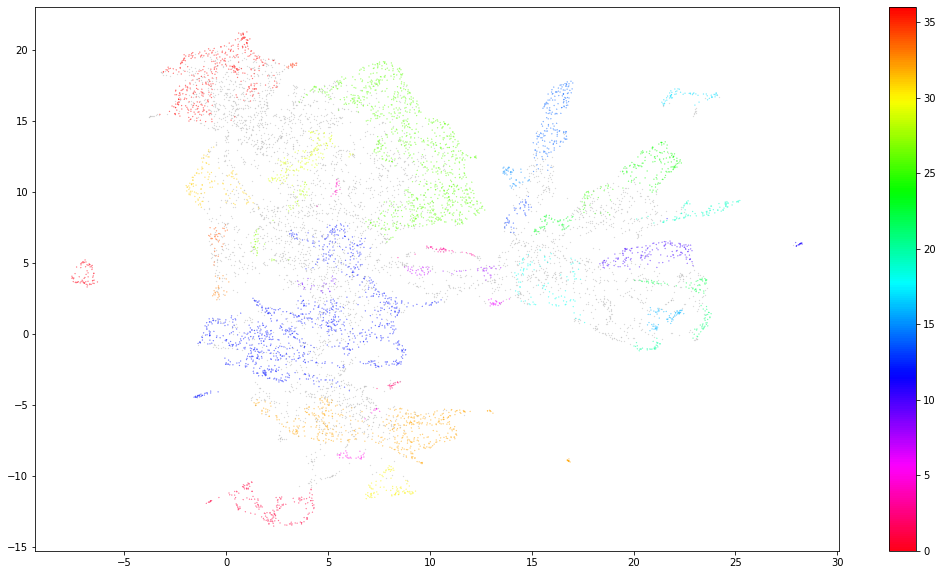

In [48]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.65, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(18, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

- It is difficult to visualize the individual clusters due to the number of topics generated

In [49]:
umap_data

array([[  4.527621 ,  -5.7394857],
       [  5.138712 ,   2.590159 ],
       [  2.5028963,   8.679066 ],
       ...,
       [ 23.360138 ,   3.8339732],
       [ -0.3597854, -11.5025625],
       [  4.1680374,  15.4798975]], dtype=float32)

In [52]:
cluster

HDBSCAN(min_cluster_size=15)

In [53]:
clustered

,x,y,labels
0,4.527621,-5.739486,32
3,-1.428055,15.843961,36
4,8.013940,-3.586685,2
5,-0.476511,7.285333,34
6,7.743479,-10.770887,30
...,...,...,...
8989,2.165540,-4.860076,32
8991,8.872366,1.932580,12
8993,0.772790,20.829700,36
8997,23.360138,3.833973,22


### Topic Creation

In [57]:
docs_df = pd.DataFrame(columns=["Doc"])
docs_df['Doc'] = df_text['cleaned_description'][:9000]
# docs_df.rename(columns = {'cleaned_description':'doc'}, inplace = True)

In [58]:
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [59]:
# 10 random rows
docs_df.sample(10)

,Doc,Topic,Doc_ID
7590,ap three shark attacks off the texas coast in the past two months are unusual but do not mean there are more sharks than normal along the beach or that they are getting bolder marine biologists and other experts say,26,7586
8768,athens during yesterday celebration of the assumption of the virgin mary the greek orthodox clergy had a stern reminder for the organizers of the olympic games no matter what the advertisements and speeches say about greece modern western orientation this country is still the domain of its decidedly traditional ubiquitous state sanctioned religion speaking over the byzantine chants of a,26,8762
7950,andre agassi had to cope with the power accuracy and consistency of max mirnyi s serve and the novelty of models acting as ball girls in his opening match at the madrid masters here last night,32,7946
5614,san diego the san francisco giants lost both the wild card lead and right fielder dustan mohr in a inning loss to the san diego padres on wednesday night,12,5610
2899,jammu prime minister manmohan singh on thursday announced lifting of the ban on recruitment in central government service in jammu and kashmir,-1,2899
5104,new york roger federer who has just won his first us open is in many people s minds a threat to pete sampras record of grand slam titles,12,5100
2208,san diego in light of interstate bakeries bankruptcy filing today here s a rehash of something i wrote two weeks ago in herb greenberg s realitycheck,-1,2208
1652,toulouse france airbus has successfully completed the first in flight trial of gsm personal mobile telephones aboard an airliner paving the way for their future widespread use,-1,1652
6704,the world trade organization starts on friday a major review of the implementation of the agreement of textiles and clothing in the third stage of theintegration process,26,6700
2371,a senior us official said on wednesday deals should not be done with hostage takers ahead of the latest deadline set by afghan islamic militants who have threatened to kill three kidnapped un workers,26,2371


- What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?
- treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF.The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.
- To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [60]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df_text['cleaned_description']))

In [61]:
tf_idf

array([[0.00010548, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00012417, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05198236,
        0.        ],
       ...,
       [0.00021095, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00110484],
       [0.00012417, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

- Now we have a single importance value for each word in a cluster which can be used to create the topic.
- If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

### Topic Representation:
- In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores.
- The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [62]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,4020
13,12,1052
27,26,968
33,32,483
37,36,391
2,1,185
15,14,185
11,10,155
30,29,142
25,24,141


In [79]:
top_n_words[7]

[('lead', 0.01884780733167728),
 ('said', 0.018363597469201326),
 ('quot', 0.01750379343849409),
 ('state', 0.01672724471740012),
 ('new', 0.016368878934913553),
 ('extending', 0.015044265133935959),
 ('people', 0.0136173405479082),
 ('ipod', 0.012474962818931257),
 ('saturday', 0.012169021541211302),
 ('season', 0.012052191940942541),
 ('chief', 0.011710493172424254),
 ('game', 0.011641295465973993),
 ('sunday', 0.01140502175796992),
 ('open', 0.011356305414430872),
 ('times', 0.01126314982418637),
 ('corp', 0.011246980874329257),
 ('officials', 0.0110007559010874),
 ('league', 0.010960912344937979),
 ('jewish', 0.010949788407794345),
 ('support', 0.010861435622683926)]

In [49]:
top_n_words[27]

[('bankruptcy', 0.1340640899793673),
 ('pilots', 0.11905436873502419),
 ('airline', 0.09209536635585473),
 ('airways', 0.07337700305268546),
 ('union', 0.070233663119105),
 ('delta', 0.06033043559623397),
 ('airlines', 0.05144277389761826),
 ('agreement', 0.050228001948227845),
 ('air', 0.049615324427226624),
 ('carrier', 0.04869469171111668),
 ('cuts', 0.04727226042030192),
 ('concessions', 0.04569165402779103),
 ('filing', 0.044828113799776664),
 ('struggling', 0.04342100145406808),
 ('avoid', 0.0432095429983715),
 ('unions', 0.04047583907499542),
 ('lines', 0.0400110463648142),
 ('plan', 0.037335447712822184),
 ('cost', 0.037258318021295866),
 ('cut', 0.0353080242231809)]

In [73]:
topic_sizes[:10]

,Topic,Size
0,-1,4020
13,12,1052
27,26,968
33,32,483
37,36,391
2,1,185
15,14,185
11,10,155
30,29,142
25,24,141


- The topic name-1 refers to all documents that did not have any topics assigned.
- he great thing about HDBSCAN is that not all documents are forced towards a certain cluster. 
- If no cluster could be found, then it is simply an outlier.

### Topic Reduction:
- There is a chance that, depending on the dataset, you will get hundreds of topics that were created
- A nifty trick that Top2Vec was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.
- by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [74]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(df_text['cleaned_description'])
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,4652
4,3,1052
12,11,968
16,15,483
17,16,391
5,4,185
2,1,185
3,2,155
13,12,142
11,10,141
